In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os import listdir
import re
from PIL import Image
from torchvision import transforms
import numpy as np


In [10]:
def svm_contour(pred_fxn, xmin=-5, xmax=5, ymin=-5, ymax=5, ngrid = 33):
    '''
    Produces a contour plot for the prediction function.

    Arguments:
        pred_fxn: Prediction function that takes an n x d tensor of test examples
        and returns your SVM's predictions.
        xmin: Minimum x-value to plot.
        xmax: Maximum x-value to plot.
        ymin: Minimum y-value to plot.
        ymax: Maximum y-value to plot.
        ngrid: Number of points to be plotted between max and min (granularity).
    '''
    with torch.no_grad():
        xgrid = torch.linspace(xmin, xmax, ngrid)
        ygrid = torch.linspace(ymin, ymax, ngrid)
        (xx, yy) = torch.meshgrid((xgrid, ygrid))
        x_test = torch.cat(
            (xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),
            dim = 2).view(-1, 2)
        zz = pred_fxn(x_test)
        zz = zz.view(ngrid, ngrid)
        cs = plt.contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(),
                         cmap = 'coolwarm')
        plt.clabel(cs)
        plt.show()

def poly_implementation(x, y, degree):
    assert x.size() == y.size(), 'The dimensions of inputs do not match!'
    with torch.no_grad():
        return (1 + (x * y).sum()).pow(degree)

def poly(degree):
    return lambda x, y: poly_implementation(x, y, degree)

def rbf_implementation(x, y, sigma):
    assert x.size() == y.size(), 'The dimensions of inputs do not match!'
    with torch.no_grad():
        return (-(x - y).norm().pow(2) / 2 / sigma / sigma).exp()

def rbf(sigma):
    return lambda x, y: rbf_implementation(x, y, sigma)

def xor_data():
    x = torch.tensor([[1, 1], [-1, 1], [-1, -1], [1, -1]], dtype=torch.float)
    y = torch.tensor([1, -1, 1, -1], dtype=torch.float)
    return x, y

''' End SVM Helpers '''

''' Start CAFE Helpers '''
IMAGE_DIR = './CAFE Gamma/' # Where the CAFE images are located
EXPRESSION_RE_TRAIN = r'\d[0-14-9]\d_([a-z])\d\.pgm'
EXPRESSION_RE_TEST = r'\d[2-3]\d_([a-z])\d\.pgm'
EXPRESSION_DICT = { # Mapping from image labels to indices and meanings
    'a': {
        'expression': 'anger',
        'index': 0
    },
    'd': {
        'expression': 'disgusted',
        'index': 1
    },
    'h': {
        'expression': 'happy',
        'index': 2
    },
    'm': {
        'expression': 'maudlin',
        'index': 3
    },
    'f': {
        'expression': 'fear',
        'index': 4
    },
    's': {
        'expression': 'surprise',
        'index': 5
    }
}
IMAGE_DIMS = (380, 240) # Dimensions of a CAFE image

transform = transforms.Compose([
    transforms.ToTensor()
])

def load_cafe(set="train"):
    files = listdir(IMAGE_DIR)

    expressions = [[] for i in range(6)]
    for file_name in files:
        if set == "train":
            expr = re.fullmatch(EXPRESSION_RE_TRAIN, file_name)
        else:
            expr = re.fullmatch(EXPRESSION_RE_TEST, file_name)
        if expr is not None:
            expressions[EXPRESSION_DICT[expr.group(1)]['index']].append(file_name)

    for i in range(len(expressions)):
        expressions[i] = [Image.open(IMAGE_DIR + file_name) for file_name in expressions[i]]

    return expressions

def get_cafe_data(set="train"):
    '''
    Returns (data, labels) where data is an n x d tensor and labels is an
    n x 1 tensor.
    '''
    images = load_cafe(set)

    # Build data and label tensors
    data = []
    labels = []

    for i, exprList in enumerate(images):
        data.extend([transform(image).reshape(-1) for image in exprList])
        labels.extend([i] * len(exprList))

    labels = torch.tensor(labels)
    data = torch.stack(data)

    return data, labels

In [3]:
class CAFENet(nn.Module):
    def __init__(self, input_size=91200, num_classes=6):
        super(CAFENet, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.linear1 = nn.Linear(self.input_size, self.num_classes, bias=True)

    def forward(self, x):
        out = self.linear1(x)
        return out

## Training the model

In [4]:
def fit(net, X, y, n_epochs=201):
    '''
    Trains the neural network with CrossEntropyLoss and an Adam optimizer on
    the training set X with training labels Y for n_epochs epochs.

    Arguments:
        net: The neural network to train
        X: n x d tensor
        y: n x 1 tensor
        n_epochs: The number of epochs to train with batch gradient descent.

    Returns:
        List of losses at every epoch, including before training
        (for use in plot_cafe_loss).
    '''
    lrate = 0.001
    
    input_size = X.shape[1]
    
#     y = torch.tensor(y, dtype =torch.float32)
    
    n_classes = torch.unique(y).shape[0]
    
    epoch_list =[]
    
#     net = CAFENet(input_size,n_classes)

    criterion = nn.CrossEntropyLoss() 

    optimizer = torch.optim.Adam(net.parameters(), lr = lrate)
    
    for epoch in range(n_epochs):
        

        #forward pass
        Y_pred = net(X)
#         print(Y_pred.shape)
#         print((y.shape))
        loss = criterion(Y_pred, y)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_list.append(loss.item())
    
#     w, b = model.parameters()
    
#     torch.save(w, 'weights')
    
#     torch.save(b, 'bias')
    
    return epoch_list

## Plotting the loss/risk

In [7]:
def plot_cafe_loss():
    '''
    Trains a CAFENet on the CAFE dataset and plots the zero'th through 200'th
    epoch's losses after training. Saves the trained network for use in
    visualize_weights.
    '''
    x, y = get_cafe_data()
    
    deep_net = CAFENet(x.shape[1], torch.unique(y).shape[0])
    
    l = fit(deep_net, x, y)
    
    torch.save(deep_net, 'Neural Network')
    
    n_epochs = 201
    
    plt.plot(range(n_epochs),l)
    
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
       

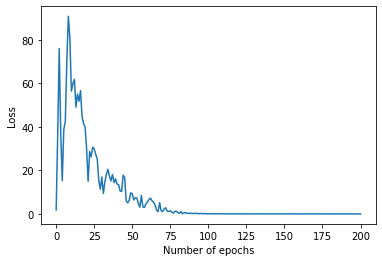

In [11]:
plot_cafe_loss()

## Visualizing the weights

In [12]:
def visualize_weights():
    '''
    Loads the CAFENet trained in plot_cafe_loss, maps the weights to the grayscale
    range, reshapes the weights into the original CAFE image dimensions, and
    plots the weights, displaying the six weight tensors corresponding to the six
    labels.
    '''
    net = torch.load('Neural Network')
    
    weights, bias = net.parameters()
    
    mini = torch.min(weights)
    
    maxi = torch.max(weights)
#     weights = weights.detach()
#     print(weights[0])
    
    weights = (weights - mini)*255/(maxi-mini)
    
    weights = weights.type(torch.LongTensor)
    
#     print(weights)
#     print(weights.shape)
    weights = weights.view(6,380,240)
#     print(weights[0])
    emotion = ['anger', 'disgusted', 'happy', 'maudlin', 'fear', 'surprise']
    plt.figure(figsize=(8, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(weights[i], cmap = 'gray')
        plt.title(emotion[i])
        

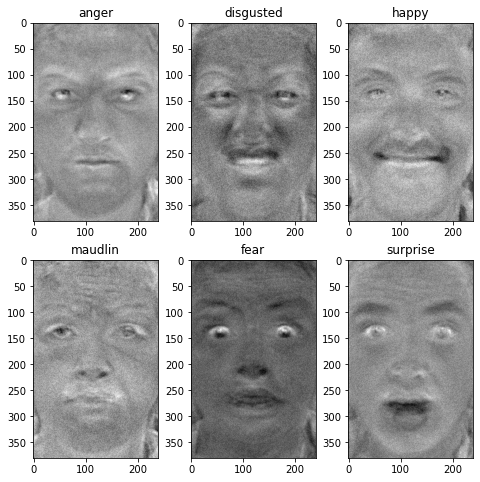

In [13]:
visualize_weights()